# Figure 2

In [6]:
from netCDF4 import Dataset
from scipy import stats
import pdb, glob, os, data, inspect, sys, numpy as np
from collections import namedtuple

from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [2]:
## Read in models
modout=xr.open_dataset('historical/globalavg/historicalEnsemble.nc')

modout['time']=pd.to_datetime(modout.time, format='%Y%m%d.%f')
modout=modout.groupby('time.year').mean(dim='time') # annual average

flux=np.array(modout.srad0+modout.trad0).squeeze()
ts=np.array(modout.temp2).squeeze()
ta=np.array(modout.t_trop).squeeze()
tag=np.array(modout.t).squeeze()
tst=np.array(modout.temp2_trop).squeeze()

In [3]:
## forcing_aed_ensemble described in notes on 170426
# forcing is already annually averaged
forcing=xr.open_dataset('historical/globalavg/forcing_aed_ensemble.nc')
forcing=np.array(forcing.f).squeeze()
forcing=forcing[:156];forcing=forcing.reshape(156,1) # make same length as model runs

print('delta F = {:.2f} W/m^2'.format(np.average(forcing[-10:]-forcing[:10])))

delta F = 2.20 W/m^2


In [4]:
## calculate lambda and theta
## output is m1all; m1all[0] is lambda, while m1all[1] is theta
s=len(forcing)

## analyze
length=10 # length of period (in years) at beginning and end to average
m1all=[]
for tempx in [ts,ta,tag,tst]:

    flux1=flux-forcing 
    
    drg=np.average(flux1[-length:,]-flux1[:length,],axis=0)
    dtg=np.average(tempx[-length:,]-tempx[:length,],axis=0)

    m1all.append(drg/dtg)

In [7]:
## read in 4xCO2 run of MPI-ESM
mpi = namedtuple('mpi', ('ts','ttrop','flux','t'))
modelname='historical/globalavg/model0003.nc'
ovar=[]
with Dataset(modelname) as fni:
    for var in ['temp2','trad0','srad0','t_trop','t']:
        fx=fni[var][:].squeeze()
        ovar.append(fx)

mpiout=mpi(ts=ovar[0],flux=ovar[1]+ovar[2],ttrop=ovar[3],t=ovar[4])

modelname='historical/globalavg/model0001.nc'
ovar=[]
with Dataset(modelname) as fni:
    for var in ['temp2','trad0','srad0','t_trop','t']:
        fx=fni[var][:].squeeze()
        ovar.append(fx)

mpicontrol=mpi(ts=ovar[0],flux=ovar[1]+ovar[2],ttrop=ovar[3],t=ovar[4])

_calculate values from the abrupt 4xCO2 model_

In [8]:
# calculate lambda for MPI model
# f1 = annual average flux
f1=(mpiout.flux-np.average(mpicontrol.flux)).reshape(len(mpiout.ts)//12,12).mean(axis=1)

# fit vs. Ts
t1=(mpiout.ts-np.average(mpicontrol.ts)).reshape(len(mpiout.ts)//12,12).mean(axis=1)
mpifitTs=stats.linregress(t1[:150],f1[:150])

# fit vs. Ta,trop
t2=(mpiout.ttrop-np.average(mpicontrol.ttrop)).reshape(len(mpiout.ttrop)//12,12).mean(axis=1)
mpifitTtrop=stats.linregress(t2[:150],f1[:150])

# fit vs. Ta,global
t3=(mpiout.t-np.average(mpicontrol.t)).reshape(len(mpiout.t)//12,12).mean(axis=1)
mpifitTa=stats.linregress(t3[:150],f1[:150])

mpiforcing=3.9 # from 1% runs
print('abrupt 4xCO2 $\lambda$: {:.2f} W/m2/K'.format(mpifitTs.slope))
print('abrupt 4xCO2 ECS: {:.2f} K'.format(-mpiforcing/mpifitTs.slope))
print('abrupt 4xCO2 $\Theta$: {:.2f} W/m2/K'.format(mpifitTtrop.slope))
print('abrupt 4xCO2 $\Theta_a$: {:.2f} W/m2/K'.format(mpifitTa.slope))
print('')

print('ECS from all 2600 years: {:.2f}'.format(np.average(t1[-30:])/2))
print('lambda from all 2600 years: {:.2f}'.format(stats.linregress(t1,f1).slope))
print('theta from all 2600 years: {:.2f}'.format(stats.linregress(t2,f1).slope))

abrupt 4xCO2 $\lambda$: -1.36 W/m2/K
abrupt 4xCO2 ECS: 2.87 K
abrupt 4xCO2 $\Theta$: -1.03 W/m2/K
abrupt 4xCO2 $\Theta_a$: -1.13 W/m2/K

ECS from all 2600 years: 3.37
lambda from all 2600 years: -0.95
theta from all 2600 years: -1.00


In [9]:
def colorplot(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # set axis positions
#     ax.yaxis.set_label_position(pspines[0]) 
#     ax.xaxis.set_label_position(pspines[1]) 
    
    for spx in ['bottom','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

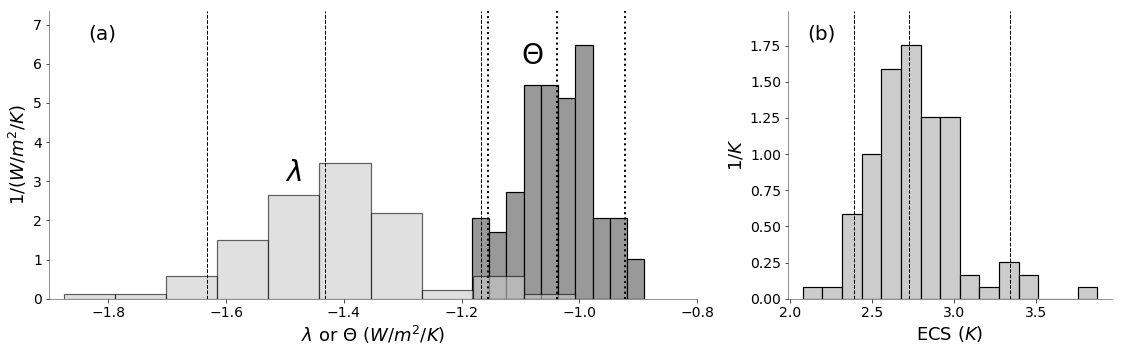

In [10]:
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# figure 2 — histogram version
fig = figure(figsize=(18,5))

rect=0.13, 0.13, 0.5, 0.8
ax=fig.add_axes(rect) 

## left-hand panel
m1=m1all[1]
ax.hist(m1,color='0.6',normed=True,edgecolor='black', linewidth=1.2)
for ii in [5,50,95]:
    ax.axvline(np.percentile(m1,ii),color='k',ls='dotted',lw=2) 

ax.text(0.06,0.9,'(a)',fontsize=20,transform=ax.transAxes)

m1=m1all[0]
ax.hist(m1,color='0.8',normed=True,alpha=0.6,edgecolor='black', linewidth=1.2)
colorplot(ax)
for ii in [5,50,95]:
    ax.axvline(np.percentile(m1,ii),color='k',ls='dashed',lw=1) 

ax.set_xlim(-1.9,-0.8)
# x1=axes[0].get_ylim();axes[0].set_ylim(x1[0],x1[1]*1.1)
    
ax.set_xlabel('$\lambda$ or $\Theta$ ($W/m^2/K$)',fontsize=18)
ax.set_ylabel('1/($W/m^2/K$)',fontsize=18)

ax.text(-1.5,3.,'$\lambda$',fontsize=28)
ax.text(-1.1,6.,'$\Theta$',fontsize=28)

x1=ax.get_ylim();ax.set_ylim(x1[0],x1[1]*1.08)

## right panel
rect=0.7, 0.13, 0.25, 0.8
ax=fig.add_axes(rect) 
ecs=-mpiforcing/np.array(m1all[0]) # calculate ECS with known forcing (see MPI forcing calc for first 70 years)
ax.hist(ecs,color='0.8',bins=15,normed=True,edgecolor='black', linewidth=1.2)
colorplot(ax)
for ii in [5,50,95]:
    ax.axvline(np.percentile(ecs,ii),color='k',ls='dashed',lw=1) 

# ax.text(0.5,0.85,'{:.2f}; {:.2f} to {:.2f}'.format(np.median(ecs),np.percentile(ecs,5),np.percentile(ecs,95)),\
#         fontsize=16,transform=ax.transAxes)
ax.text(0.06,0.9,'(b)',fontsize=20,transform=ax.transAxes)

x1=ax.get_ylim();ax.set_ylim(x1[0],x1[1]*1.08)
ax.set_xlabel('ECS ($K$)',fontsize=18)
ax.set_ylabel('$1/K$',fontsize=18);

# savefig('fig2.pdf')

In [13]:
print('range of ECS: {:.2f} to {:.2f}'.format(np.min(ecs),np.max(ecs)))
print('5-95% range of ECS: {:.2f} to {:.2f}'.format(np.percentile(ecs,5),np.percentile(ecs,95)))
print('median of ECS: {:.2f}'.format(np.median(ecs)))
print('average of ECS: {:.2f}'.format(np.average(ecs)))

range of ECS: 2.08 to 3.87
5-95% range of ECS: 2.39 to 3.34
median of ECS: 2.72
average of ECS: 2.76


In [14]:
print('range of lambda: {:.2f} to {:.2f}'.format(np.min(m1all[0]),np.max(m1all[0])))
print('5-95% range of lambda: {:.2f} to {:.2f}'.format(np.percentile(m1all[0],5),np.percentile(m1all[0],95)))
print('median of lambda: {:.2f}'.format(np.median(m1all[0])))
print('average of lambda: {:.2f}'.format(np.average(m1all[0])))

range of lambda: -1.88 to -1.01
5-95% range of lambda: -1.63 to -1.17
median of lambda: -1.43
average of lambda: -1.42


In [15]:
print('range of theta: {:.2f} to {:.2f}'.format(np.min(m1all[1]),np.max(m1all[1])))
print('5-95% range of theta: {:.2f} to {:.2f}'.format(np.percentile(m1all[1],5),np.percentile(m1all[1],95)))
print('median of theta: {:.2f}'.format(np.median(m1all[1])))
print('average of theta: {:.2f}'.format(np.average(m1all[1])))

range of theta: -1.18 to -0.89
5-95% range of theta: -1.16 to -0.92
median of theta: -1.04
average of theta: -1.04


## estimate impact of other lengths

this code calculates how the statistics of the ensemble change if the averaging period changes

In [20]:
<<>> work on this <<>>
s=len(forcing)

## analyze
for length in [10,25,50]:

	m1all=[]
	for tempx in [ts,ta,tag,tst]:

		flux1=flux-forcing 

		drg=np.average(flux1[-length:,]-flux1[:length,],axis=0)
		dtg=np.average(tempx[-length:,]-tempx[:length,],axis=0)

		m1all.append(drg/dtg)
<<>> print out stats here
        # calculate lambda for abrupt runs
		mod1=modout[3]
		flux=anomaly(mod1.flux) # fluxes are the same for all calcs

		tvar=varn
		if latr == '30': tvar = tvar+'trop'
		commandStr='t1=anomaly(mod1.{})'.format(tvar)
		exec(commandStr)
		a1.append(stats.linregress(t1,flux).slope)
		a1.append(stats.linregress(t1[:150*12],flux[:150*12]).slope)
		abrupt.append(a1)
		print('{} {} {}: {:.2f} +/- {:.2f}, {:.2}'.format(length,latr,varn,np.average(m1),np.std(m1),\
            np.max(m1)-np.min(m1)))

KeyError: 3

## older stuff

old version w/ values from 4xCO2 run

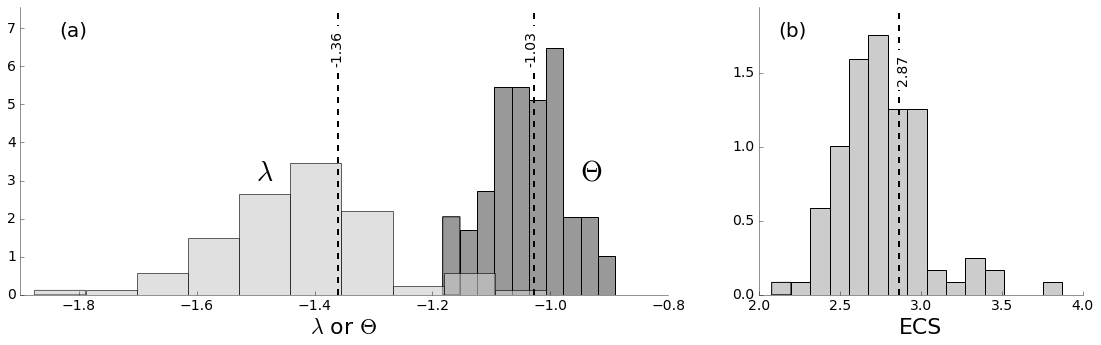

In [20]:
import matplotlib as mpl
label_size = 8
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# figure 2 — histogram version
fig = figure(figsize=(18,5))

rect=0.13, 0.13, 0.5, 0.8
ax=fig.add_axes(rect) 

## left-hand panel
m1=m1all[1]
ax.hist(m1,color='0.6',normed=True)
ax.axvline(mpifitTtrop.slope,color='k',ls='dashed',lw=2) # from MPI climate sensitivity calc

# ax.text(0.06,0.7,'$\Theta$: {:.2f};{:.2f} to {:.2f}'.format(np.median(m1),np.percentile(m1,5),np.percentile(m1,95)),\
#         fontsize=16,transform=ax.transAxes)
ax.text(0.06,0.9,'(a)',fontsize=20,transform=ax.transAxes)

m1=m1all[0]
ax.hist(m1,color='0.8',normed=True,alpha=0.6)
colorplot(ax)
ax.axvline(mpifitTs.slope,color='k',ls='dashed',lw=2) # from MPI climate sensitivity calc

ax.text(mpifitTtrop.slope-0.005,6.65,'{:.2f}'.format(mpifitTtrop.slope),rotation=90,fontsize=14,backgroundcolor='w',ha='center') 
ax.text(mpifitTs.slope,6.65,'{:.2f}'.format(mpifitTs.slope),rotation=90,fontsize=14,backgroundcolor='w',ha='center') 

ax.set_xlim(-1.9,-0.8)
# x1=axes[0].get_ylim();axes[0].set_ylim(x1[0],x1[1]*1.1)
    
ax.set_xlabel('$\lambda$ or $\Theta$',fontsize=22)

# ax.text(0.061,0.78,'$\lambda$: {:.2f};{:.2f} to {:.2f}'.format(np.median(m1),np.percentile(m1,5),np.percentile(m1,95)),\
#         fontsize=16,transform=ax.transAxes)

ax.text(-1.5,3.,'$\lambda$',fontsize=28)
ax.text(-0.95,3.,'$\Theta$',fontsize=28)

x1=ax.get_ylim();ax.set_ylim(x1[0],x1[1]*1.08)

## right panel
rect=0.7, 0.13, 0.25, 0.8
ax=fig.add_axes(rect) 
ecs=-mpiforcing/np.array(m1all[0]) # calculate ECS with known forcing (see MPI forcing calc for first 70 years)
ax.hist(ecs,color='0.8',bins=15,normed=True)
colorplot(ax)
ax.axvline(-mpiforcing/mpifitTs.slope,color='k',ls='dashed',lw=2)
ax.text(-mpiforcing/mpifitTs.slope+0.025,1.55,'{:.2f}'.format(-mpiforcing/mpifitTs.slope),\
    rotation=90,fontsize=14,backgroundcolor='w',ha='center') 

# ax.text(0.5,0.85,'{:.2f}; {:.2f} to {:.2f}'.format(np.median(ecs),np.percentile(ecs,5),np.percentile(ecs,95)),\
#         fontsize=16,transform=ax.transAxes)
ax.text(0.06,0.9,'(b)',fontsize=20,transform=ax.transAxes)

x1=ax.get_ylim();ax.set_ylim(x1[0],x1[1]*1.08)
ax.set_xlabel('ECS',fontsize=22)

# savefig('fig2.pdf')

### Calculation using global-average Ta

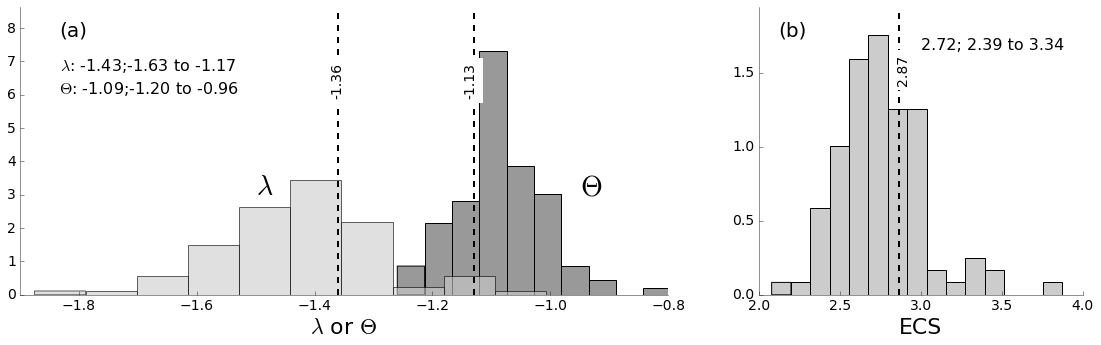

In [92]:
import matplotlib as mpl
label_size = 8
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# figure 2 — histogram version
fig = figure(figsize=(18,5))

rect=0.13, 0.13, 0.5, 0.8
ax=fig.add_axes(rect) 

## left-hand panel
m1=m1all[2]
ax.hist(m1,color='0.6',normed=True)
ax.axvline(mpifitTa.slope,color='k',ls='dashed',lw=2) # from MPI climate sensitivity calc

# ax.text(0.06,0.7,'$\Theta$: {:.2f}$\pm${:.2f}, {:.2f}'.format(np.median(m1),np.std(m1),(np.max(m1)-np.min(m1))),\
#         fontsize=20,transform=ax.transAxes)
ax.text(0.06,0.7,'$\Theta$: {:.2f};{:.2f} to {:.2f}'.format(np.median(m1),np.percentile(m1,5),np.percentile(m1,95)),\
        fontsize=16,transform=ax.transAxes)
ax.text(0.06,0.9,'(a)',fontsize=20,transform=ax.transAxes)

m1=m1all[0]
ax.hist(m1,color='0.8',normed=True,alpha=0.6)
colorplot(ax)
ax.axvline(mpifitTs.slope,color='k',ls='dashed',lw=2) # from MPI climate sensitivity calc

ax.text(mpifitTa.slope-0.005,6.65,'{:.2f}'.format(mpifitTa.slope),rotation=90,fontsize=14,backgroundcolor='w',ha='center') 
ax.text(mpifitTs.slope,6.65,'{:.2f}'.format(mpifitTs.slope),rotation=90,fontsize=14,backgroundcolor='w',ha='center') 

ax.set_xlim(-1.9,-0.8)
# x1=axes[0].get_ylim();axes[0].set_ylim(x1[0],x1[1]*1.1)
    
ax.set_xlabel('$\lambda$ or $\Theta$',fontsize=22)

# ax.text(0.06,0.8,'$\lambda$: {:.2f}$\pm${:.2f}, {:.2f}'.format(np.median(m1),np.std(m1),(np.max(m1)-np.min(m1))),\
#         fontsize=20,transform=ax.transAxes)
ax.text(0.061,0.78,'$\lambda$: {:.2f};{:.2f} to {:.2f}'.format(np.median(m1),np.percentile(m1,5),np.percentile(m1,95)),\
        fontsize=16,transform=ax.transAxes)

ax.text(-1.5,3.,'$\lambda$',fontsize=28)
ax.text(-0.95,3.,'$\Theta$',fontsize=28)

x1=ax.get_ylim();ax.set_ylim(x1[0],x1[1]*1.08)

## right panel
rect=0.7, 0.13, 0.25, 0.8
ax=fig.add_axes(rect) 
ecs=-mpiforcing/np.array(m1all[0]) # calculate ECS with known forcing (see MPI forcing calc for first 70 years)
ax.hist(ecs,color='0.8',bins=15,normed=True)
colorplot(ax)
ax.axvline(-mpiforcing/mpifitTs.slope,color='k',ls='dashed',lw=2)
ax.text(-mpiforcing/mpifitTs.slope+0.025,1.55,'{:.2f}'.format(-mpiforcing/mpifitTs.slope),\
    rotation=90,fontsize=14,backgroundcolor='w',ha='center') 

# ax.text(0.65,0.92,'%5.2f$\pm$%4.2f' % (np.average(ecs),np.std(ecs)),\
#         fontsize=16,transform=ax.transAxes)
# ax.text(0.8,0.82,'%4.2f' % (np.max(ecs)-np.min(ecs)),\
#         fontsize=16,transform=ax.transAxes)
# ax.text(0.5,0.85,'{:.2f}$\pm${:.2f}, {:.1f}'.format(np.median(ecs),np.std(ecs),(np.max(ecs)-np.min(ecs))),\
#         fontsize=20,transform=ax.transAxes)
ax.text(0.5,0.85,'{:.2f}; {:.2f} to {:.2f}'.format(np.median(ecs),np.percentile(ecs,5),np.percentile(ecs,95)),\
        fontsize=16,transform=ax.transAxes)
ax.text(0.06,0.9,'(b)',fontsize=20,transform=ax.transAxes)

x1=ax.get_ylim();ax.set_ylim(x1[0],x1[1]*1.08)
ax.set_xlabel('ECS',fontsize=22)

Calculation using tropical-average Ts

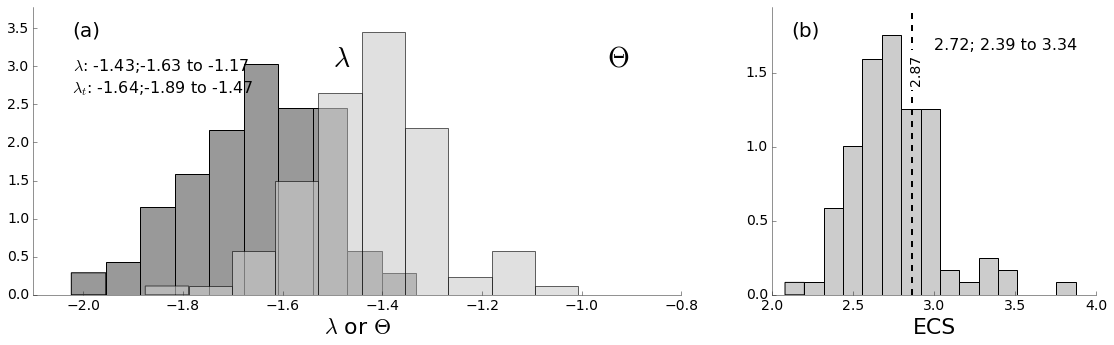

In [95]:
import matplotlib as mpl
label_size = 8
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# figure 2 — histogram version
fig = figure(figsize=(18,5))

rect=0.13, 0.13, 0.5, 0.8
ax=fig.add_axes(rect) 

## left-hand panel
m1=m1all[3]
ax.hist(m1,color='0.6',normed=True)

# ax.text(0.06,0.7,'$\Theta$: {:.2f}$\pm${:.2f}, {:.2f}'.format(np.median(m1),np.std(m1),(np.max(m1)-np.min(m1))),\
#         fontsize=20,transform=ax.transAxes)
ax.text(0.06,0.7,'$\lambda_t$: {:.2f};{:.2f} to {:.2f}'.format(np.median(m1),np.percentile(m1,5),np.percentile(m1,95)),\
        fontsize=16,transform=ax.transAxes)
ax.text(0.06,0.9,'(a)',fontsize=20,transform=ax.transAxes)

m1=m1all[0]
ax.hist(m1,color='0.8',normed=True,alpha=0.6)
colorplot(ax)

ax.set_xlim(-2.1,-0.8)
# x1=axes[0].get_ylim();axes[0].set_ylim(x1[0],x1[1]*1.1)
    
ax.set_xlabel('$\lambda$ or $\Theta$',fontsize=22)

# ax.text(0.06,0.8,'$\lambda$: {:.2f}$\pm${:.2f}, {:.2f}'.format(np.median(m1),np.std(m1),(np.max(m1)-np.min(m1))),\
#         fontsize=20,transform=ax.transAxes)
ax.text(0.061,0.78,'$\lambda$: {:.2f};{:.2f} to {:.2f}'.format(np.median(m1),np.percentile(m1,5),np.percentile(m1,95)),\
        fontsize=16,transform=ax.transAxes)

ax.text(-1.5,3.,'$\lambda$',fontsize=28)
ax.text(-0.95,3.,'$\Theta$',fontsize=28)

x1=ax.get_ylim();ax.set_ylim(x1[0],x1[1]*1.08)

## right panel
rect=0.7, 0.13, 0.25, 0.8
ax=fig.add_axes(rect) 
ecs=-mpiforcing/np.array(m1all[0]) # calculate ECS with known forcing (see MPI forcing calc for first 70 years)
ax.hist(ecs,color='0.8',bins=15,normed=True)
colorplot(ax)
ax.axvline(-mpiforcing/mpifitTs.slope,color='k',ls='dashed',lw=2)
ax.text(-mpiforcing/mpifitTs.slope+0.025,1.55,'{:.2f}'.format(-mpiforcing/mpifitTs.slope),\
    rotation=90,fontsize=14,backgroundcolor='w',ha='center') 

# ax.text(0.65,0.92,'%5.2f$\pm$%4.2f' % (np.average(ecs),np.std(ecs)),\
#         fontsize=16,transform=ax.transAxes)
# ax.text(0.8,0.82,'%4.2f' % (np.max(ecs)-np.min(ecs)),\
#         fontsize=16,transform=ax.transAxes)
# ax.text(0.5,0.85,'{:.2f}$\pm${:.2f}, {:.1f}'.format(np.median(ecs),np.std(ecs),(np.max(ecs)-np.min(ecs))),\
#         fontsize=20,transform=ax.transAxes)
ax.text(0.5,0.85,'{:.2f}; {:.2f} to {:.2f}'.format(np.median(ecs),np.percentile(ecs,5),np.percentile(ecs,95)),\
        fontsize=16,transform=ax.transAxes)
ax.text(0.06,0.9,'(b)',fontsize=20,transform=ax.transAxes)

x1=ax.get_ylim();ax.set_ylim(x1[0],x1[1]*1.08)
ax.set_xlabel('ECS',fontsize=22)

### calculate stats for $T_{500}$

In [12]:
s=len(forcing)

## analyze
length=10;m1all2=[]
m1=[]
for mn in range(101,201):
	print '%04i ' % mn,
	sys.stdout.flush()

	mod1=modout[mn]
	flux=mod1.flux-forcing # fluxes are the same for all calcs
	t1=mod1.t

	drg.append(np.average(flux[-length*12:]-flux[:length*12]))
	dtg.append(np.average(t1[-length*12:]-t1[:length*12]))
	m1.append(drg[-1]/dtg[-1])

m1all2.append(m1)

0101  0102  0103  0104  0105  0106  0107  0108  0109  0110  0111  0112  0113  0114  0115  0116  0117  0118  0119  0120  0121  0122  0123  0124  0125  0126  0127  0128  0129  0130  0131  0132  0133  0134  0135  0136  0137  0138  0139  0140  0141  0142  0143  0144  0145  0146  0147  0148  0149  0150  0151  0152  0153  0154  0155  0156  0157  0158  0159  0160  0161  0162  0163  0164  0165  0166  0167  0168  0169  0170  0171  0172  0173  0174  0175  0176  0177  0178  0179  0180  0181  0182  0183  0184  0185  0186  0187  0188  0189  0190  0191  0192  0193  0194  0195  0196  0197  0198  0199  0200 


In [13]:
print 'average and standard deviation of $\Theta$: {:.2f} +/- {:.2f}'.format(np.average(m1all2[0]),np.std(m1all2[0]))

average and standard deviation of $\Theta$: -1.09 +/- 0.07
